# Create Supplemental Figures 1 and 2
S1: SST Trends from Obs

S2: SWCF for CMIP6 and Obs

In [1]:
import math
import xarray as xr
import numpy as np
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress

# Loading

### Load SST Trends

In [2]:
SST_PRODUCTS = ["HadISST-1.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA", "COBE", "NOAA-OISST-v2.1", "NOAA-OISST-v2.0"]
sst_datasets = []
for sst_product in SST_PRODUCTS:
    sst_datasets.append(
        xr.open_dataset(f"data/obs/{sst_product}_sst_trends.nc")
    )

###  LOAD SWCF 

In [3]:
def load_swcf(feedback: str ="swcf", toa: bool = True):
    """Load SWCF defined for surface or TOA"""
    if toa:
        swcf_cmip6 = xr.open_dataset(f"data/piControl/swcf_cmip6_monthly_1850-2000.nc", chunks="auto").rename({"lat": "latitude", "lon": "longitude"})
        swcf_cmip5 = xr.open_dataset(f"data/piControl/swcf_cmip5_monthly_1850-2000.nc", chunks="auto").rename({"lat": "latitude", "lon": "longitude"})

        swcf_cmip6_epsa = xr.open_dataset(f"data/piControl/swcf_east_sa_cmip6_v3.nc")
        swcf_cmip5_epsa = xr.open_dataset(f"data/piControl/swcf_east_sa_cmip5_v3.nc")

        swcf_obs = xr.open_dataset("data/obs/swcf_toa_obs.nc")
        swcf_epsa_obs = xr.open_dataset("data/obs/swcf_toa_epsa_obs.nc")
    else:
        swcf_obs = xr.open_dataset("data/obs/swcf_surface_obs.nc")
        swcf_epsa_obs = xr.open_dataset("data/obs/swcf_surface_epsa_obs.nc")

        swcf_cmip6 = xr.open_dataset(f"data/piControl/swcf-surface-cmip6_monthly_1850-2000.nc", chunks="auto").rename({"lat": "latitude", "lon": "longitude"})
        swcf_cmip5 = xr.open_dataset(f"data/piControl/swcf-surface-cmip5_monthly_1850-2000.nc", chunks="auto").rename({"lat": "latitude", "lon": "longitude"})

        swcf_cmip6_epsa = xr.open_dataset(f"data/piControl/cf_east_sa_swcf-surface_cmip6_v3.nc")
        swcf_cmip5_epsa = xr.open_dataset(f"data/piControl/cf_east_sa_swcf-surface_cmip5_v3.nc")

    return swcf_cmip6, swcf_cmip5, swcf_cmip6_epsa, swcf_cmip5_epsa, swcf_obs, swcf_epsa_obs

    
swcf_cmip6, swcf_cmip5, swcf_cmip6_epsa, swcf_cmip5_epsa, swcf_obs, swcf_epsa_obs = load_swcf(toa=True)
# swcf_cmip6, swcf_cmip5, swcf_cmip6_epsa, swcf_cmip5_epsa, swcf_obs, swcf_epsa_obs = load_swcf(toa=False)

# Plotting Utils 

In [4]:
def global_plot(ax, data, lon, lat, cmap, pvalues=None, winds=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    if winds is not None: 
        # quiver([X, Y], U, V, [C], **kwargs)
        ax.quiver(lon[::3], lat[::3], winds["U10"][::3,::3], winds["V10"][::3,::3], scale=20, transform=ccrs.PlateCarree())
    
    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # # Draw triangular region
    # lat_min, lat_max = -40, 0
    # lon_min, lon_max = -180, -70
    # ax.plot(
    #     [lon_min, lon_max, lon_max, lon_min], 
    #     [lat_max, lat_max, lat_min, lat_max], 
    #     color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    # )

    bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")

    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -65, 65
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )


In [5]:
def get_agreement(swcf_obs, swcf_cmip):
   # Count where models and obs agree
   agreement_count = xr.where(
      ((swcf_obs > 0) & (swcf_cmip["swcf"] > 0)) |
      ((swcf_obs < 0) & (swcf_cmip["swcf"] < 0)), 
      1,
      0
   ).sum("model")
   # If count is half or more of models, then pvalue is 0
   pvalues = xr.where(
      agreement_count >= math.ceil(len(swcf_cmip.model.values)/2),
      0, # Agree 
      1, # Disagree
   )
   return pvalues

In [6]:
swcf_obs

<xarray.Dataset>
Dimensions:                   (latitude: 72, longitude: 144, bnds: 2)
Coordinates:
  * latitude                  (latitude) float64 -88.75 -86.25 ... 86.25 88.75
  * longitude                 (longitude) float64 -178.8 -176.2 ... 176.2 178.8
Dimensions without coordinates: bnds
Data variables:
    PCMDI-AMIP-1-1-9          (latitude, longitude) float64 ...
    longitude_bnds            (longitude, bnds) float64 ...
    latitude_bnds             (latitude, bnds) float64 ...
    PCMDI-AMIP-1-1-9-pvalues  (latitude, longitude) float64 ...
    ERA5                      (latitude, longitude) float64 ...
    ERA5-pvalues              (latitude, longitude) float64 ...
    NOAA                      (latitude, longitude) float64 ...
    NOAA-pvalues              (latitude, longitude) float64 ...
    COBE                      (latitude, longitude) float64 ...
    COBE-pvalues              (latitude, longitude) float64 ...
    NOAA-OISST-v2.1           (latitude, longitude) float64 ...
    NOAA-OISST-v2.1-pvalues   (latitude, longitude) float64 ...

# SWCF Spatial Maps

In [7]:
def swcf_agu23():
    fig = plt.figure(figsize=(12,12))
    gs = GridSpec(3, 1)
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
    ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
    ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=180))
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.15)


    levels = np.arange(-10, 11, 1)
    cmap = "RdBu_r"

    img = global_plot(
        ax1,
        data=swcf_obs["PCMDI-AMIP-1-1-9"],
        lat=swcf_obs["PCMDI-AMIP-1-1-9"].latitude,
        lon=swcf_obs["PCMDI-AMIP-1-1-9"].longitude,
        pvalues=swcf_obs["PCMDI-AMIP-1-1-9-pvalues"],
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Set pvalues equal to 0 where majority of models in SWCF_CMIP6 agree with sign of SWCF_Obs
    pvalues_cmip6 = get_agreement(swcf_obs=swcf_obs["PCMDI-AMIP-1-1-9"], swcf_cmip=swcf_cmip6)
    pvalues_cmip5 = get_agreement(swcf_obs=swcf_obs["PCMDI-AMIP-1-1-9"], swcf_cmip=swcf_cmip5)


    # Plot Figure S2b: SWCF CMIP6
    img = global_plot(
        ax2,
        data=swcf_cmip6["swcf"].mean("model"),
        lat=swcf_cmip6.latitude,
        lon=swcf_cmip6.longitude,
        pvalues=pvalues_cmip6,
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Plot Figure S2c: SWCF CMIP5
    img = global_plot(
        ax3,
        data=swcf_cmip5["swcf"].mean("model"),
        lat=swcf_cmip5.latitude,
        lon=swcf_cmip5.longitude,
        pvalues=pvalues_cmip5,
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    # Set Right Title: Name of Product
    title_fontsize = 12
    ax1.set_title("CERES-EBAF", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title("CMIP6", loc="right", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title("CMIP5", loc="right", fontweight="bold", fontsize=title_fontsize)

    # Set Left Title: Area Weighted SWCF in EPSA
    epsa6 = np.around(swcf_cmip6_epsa["swcf"].mean("model").values, 3)
    epsa5 = np.around(swcf_cmip5_epsa["swcf"].mean("model").values, 3)
    epsaObs = np.around(swcf_epsa_obs["PCMDI-AMIP-1-1-9"].values, 3)
    ax1.set_title(epsaObs, loc="left", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title(epsa6, loc="left", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title(epsa5, loc="left", fontweight="bold", fontsize=title_fontsize)

    cbar = fig.colorbar(img, ax=[ax1, ax2, ax3], orientation='vertical', location="right", fraction=.1, pad=0.01)
    cbar.ax.set_title(r"$Wm^{-2}K^{-1}$", fontsize=12, fontweight="bold")

    plt.savefig(f"manuscript_figures/SI_Figures/Figure_SX_SWCF.png", dpi=400, bbox_inches='tight')


### Plot SWCF for AGU23

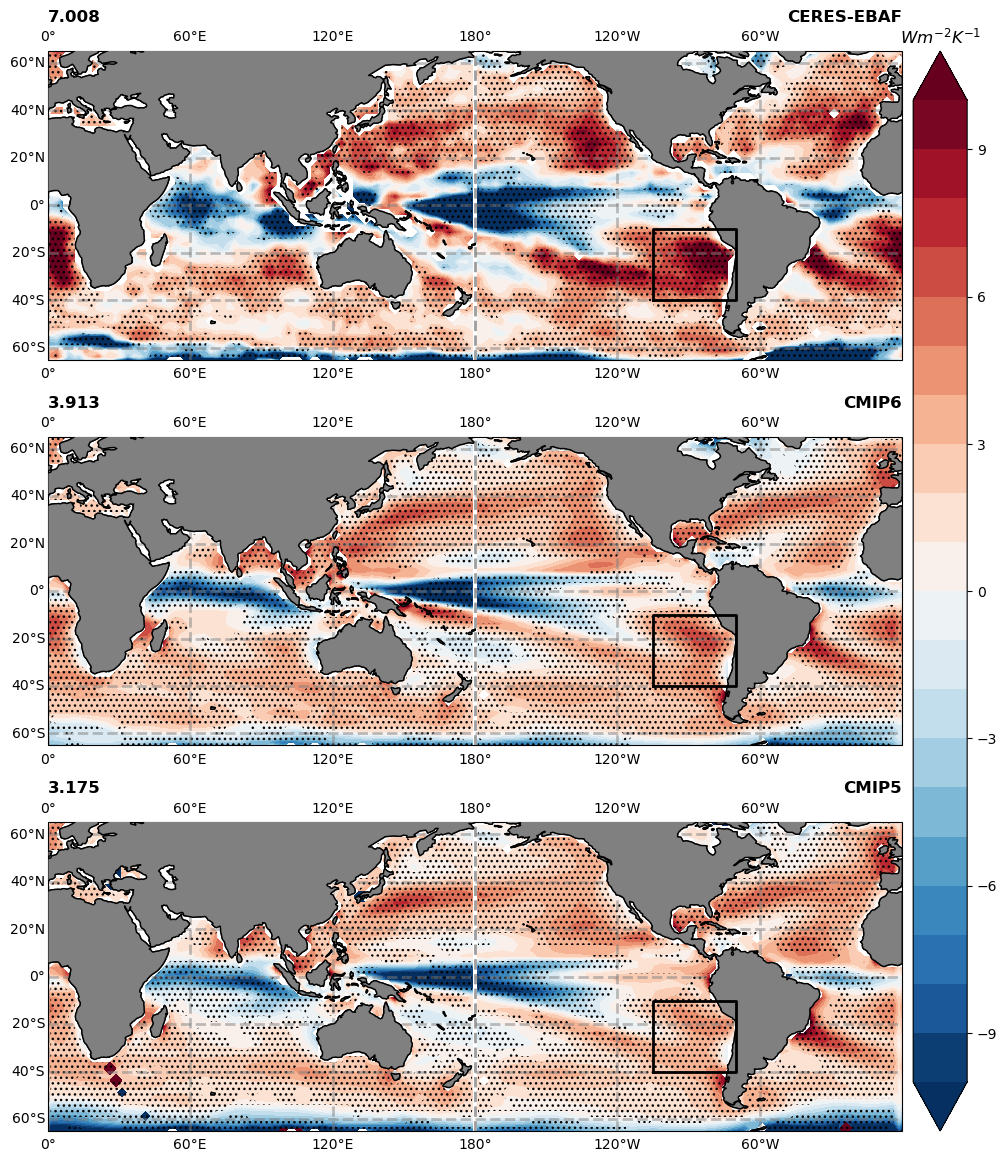

In [8]:
swcf_agu23()

# Plot SWCF TOA vs Surface

In [6]:
# Get shared models between swcf_eastsa_cmip6 and tos_grad_trend_cmip6
def get_shared_models(ds1, ds2):
    shared_models = list(set(ds1.model.values).intersection(set(ds2.model.values)))
    return ds1.sel(model=shared_models).values, ds2.sel(model=shared_models).values

_, _, swcf_cmip6_epsa_toa, swcf_cmip5_epsa_toa, _, swcf_epsa_obs_toa = load_swcf(toa=True)
_, _, swcf_cmip6_epsa_surface, swcf_cmip5_epsa_surface, _, swcf_epsa_obs_surface = load_swcf(toa=False)
    
swcf_cmip5_epsa_toa, swcf_cmip5_epsa_surface = get_shared_models(swcf_cmip5_epsa_toa["swcf"], swcf_cmip5_epsa_surface["swcf"])
swcf_cmip6_epsa_toa, swcf_cmip6_epsa_surface = get_shared_models(swcf_cmip6_epsa_toa["swcf"], swcf_cmip6_epsa_surface["swcf"])

SST_PRODUCTS = ["HadISST-1.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA", "COBE", "NOAA-OISST-v2.1", "NOAA-OISST-v2.0"]
swcf_epsa_obs_toa = [swcf_epsa_obs_toa[sst_prod].values for sst_prod in SST_PRODUCTS]
swcf_epsa_obs_surface = [swcf_epsa_obs_surface[sst_prod].values for sst_prod in SST_PRODUCTS]

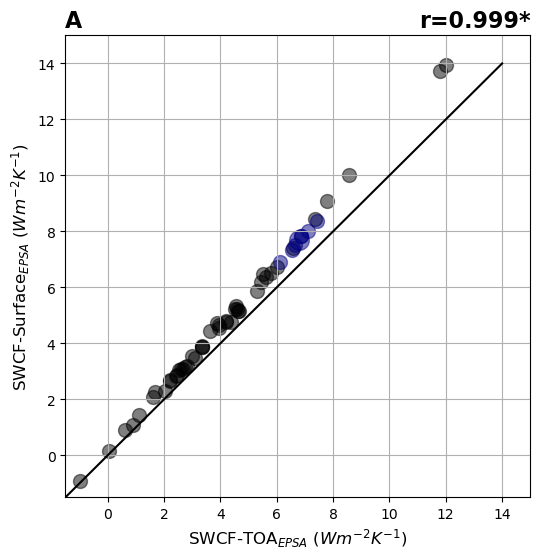

In [7]:
def scatter(x, y, x_obs, y_obs) -> None:
    # Set the default color cycle
    colors = ['black','navy','#7570b3']
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.scatter(x, y, s=100, alpha=.5, edgecolor="black", color=colors[0])
    res = linregress(x, y)
    r = np.around(res.rvalue, 3)

    # Vertical line for avg and std of obs
    ax.scatter(np.mean(x_obs), np.mean(y_obs), s=200, alpha=.5, edgecolor="navy", color=colors[1])
    ax.scatter(x_obs, y_obs, s=100, alpha=.5, edgecolor="navy", color=colors[1])

    ax.plot(np.arange(-2, 15), np.arange(-2, 15), color="black")
    ax.grid()
    ax.set_ylim(-1.5, 15)
    ax.set_xlim(-1.5, 15)

    axis_fontsize = 12
    ax.set_xlabel(r"SWCF-TOA$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)
    ax.set_ylabel(r"SWCF-Surface$_{EPSA}$ ($Wm^{-2}K^{-1}$)", fontsize=axis_fontsize)

    # Set Title
    ax.set_title(f"r={r}*", loc="right", fontweight="bold", fontsize=16)
    ax.set_title(f"A", loc="left", fontweight="bold", fontsize=16)

    plt.savefig(f"SWCF_TOA_vs_Surface.png", dpi=1200, bbox_inches='tight')

scatter(
    x=swcf_cmip6_epsa_toa, 
    y=swcf_cmip6_epsa_surface,
    x_obs=swcf_epsa_obs_toa, 
    y_obs=swcf_epsa_obs_surface,
)

In [ ]:
# swcf_cmip6_epsa = xr.open_dataset(f"data/piControl/cf_east_sa_net-surface_cmip6_v3.nc")
# swcf_cmip5_epsa = xr.open_dataset(f"data/piControl/cf_east_sa_net-surface_cmip5_v3.nc")

# scatter(
#     x=lwcf_cmip6_epsa_toa, 
#     y=lwcf_cmip6_epsa_surface,
#     x_obs=lwcf_epsa_obs_toa, 
#     y_obs=lwcf_epsa_obs_surface,
# )